In [1]:
import torch
from torch import nn, optim

import monai
import numpy as np
import nibabel as nib
from glob import glob
from matplotlib import pyplot as plt
import copy
from scipy.spatial import distance_matrix
from monai.transforms import (
    Activations,
    AsChannelFirstD,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
    Resized
)

from monai.data import (
    ArrayDataset, GridPatchDataset, create_test_image_3d, PatchIter)
from monai.utils import first
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, decollate_batch
from natsort import natsorted
import umap

from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
from scipy.special import softmax

import sklearn

In [2]:
LIEU = 'sebastian_insel'

if LIEU=='sebastian_insel':
    root_exp  = '/home/otarola/miccai22/fedem/'
    root_data = '/str/data/ASAP/miccai22_data/isles/federated/'
    isles_nifti__dir_paths = natsorted(glob(root_data+"**/**/**/"))

if LIEU=='sebastian_laptop':
    root_exp  = '/Users/sebastianotalora/work/postdoc/federated_learning/fedem/'
    root_data = '/Users/sebastianotalora/work/postdoc/federated_learning/data/'
    isles_nifti__dir_paths = natsorted(glob(root_data+'brats/'"**/**/"))
print(len(isles_nifti__dir_paths))#Should be 94
#print(isles_nifti__dir_paths)

94


In [67]:
def average_weights_with_smax_samplesweight(local_trained_weights, loaders_lengths):
    """Returns the average of the weights.
       local_trained_weights: The list of tensors (of the same shape) that will be averaged
    """
    weights_samples_scaling = softmax(loaders_lengths)    
    avg_weights = copy.deepcopy(local_trained_weights[0])
    
    for key in avg_weights.keys():
        avg_weights[key] = avg_weights[key]*weights_samples_scaling[0]
        
    for key in avg_weights.keys():
        for i in range(1, len(local_trained_weights)):
            avg_weights[key] += (weights_samples_scaling[i])*local_trained_weights[i][key]
        avg_weights[key] = torch.div(avg_weights[key], len(local_trained_weights))
    return avg_weights


In [4]:
def average_weights_with_numsamplesweight(local_trained_weights, loaders_lengths):
    """Returns the average of the weights.
       local_trained_weights: The list of tensors (of the same shape) that will be averaged
    """
    #weights_samples_scaling = softmax(loaders_lengths)
    # Initialize copy model weights with the untrained model weights.
    #weights_samples_scaling = np.array(loaders_lengths)/np.array(loaders_lengths).sum()

    avg_weights = copy.deepcopy(local_trained_weights[0])
    for key in avg_weights.keys():
        avg_weights[key] = avg_weights[key]*loaders_lengths[0]
        
    for key in avg_weights.keys():
        for i in range(1, len(local_trained_weights)):
            avg_weights[key] += (loaders_lengths[i])*local_trained_weights[i][key]
        avg_weights[key] = torch.div(avg_weights[key], len(local_trained_weights))
    return avg_weights


In [5]:
def average_weights_with_embeddings(local_trained_weights, embeddings):
    """Returns the average of the weights.
       local_trained_weights: The list of tensors (of the same shape) that will be averaged
    """
    # Initialize copy model weights with the untrained model weights.
    avg_weights = copy.deepcopy(local_trained_weights[0])
    for key in avg_weights.keys():
        for i in range(1, len(local_trained_weights)):
            avg_weights[key] += local_trained_weights[i][key]
        avg_weights[key] = torch.div(avg_weights[key], len(local_trained_weights))
    return avg_weights


In [6]:
def average_weights(local_trained_weights):
    """Returns the average of the weights.
       local_trained_weights: The list of tensors (of the same shape) that will be averaged
    """
    # Initialize copy model weights with the untrained model weights.
    avg_weights = copy.deepcopy(local_trained_weights[0])
    for key in avg_weights.keys():
        for i in range(1, len(local_trained_weights)):
            avg_weights[key] += local_trained_weights[i][key]
        avg_weights[key] = torch.div(avg_weights[key], len(local_trained_weights))
    return avg_weights


In [7]:
#loading volume paths
LOCATION = 'scan' #laptop
if LOCATION == 'scan':
    isles_data_root = '/str/data/ASAP/miccai22_data/isles/federated/'
    exp_root = '/home/otarola/miccai22/fedem/'

if LOCATION == 'laptop':
    isles_data_root = '/data/ASAP/miccai22_data/isles/federated/'

modality = 'Tmax'

center1_cbf_paths_train  = sorted(glob(isles_data_root+'center1/train/'+'/**/*'+modality+'*/*.nii'))
center1_cbf_paths_valid  = sorted(glob(isles_data_root+'center1/valid/'+'/**/*'+modality+'*/*.nii'))
center1_cbf_paths_test   = sorted(glob(isles_data_root+'center1/test/'+'/**/*'+modality+'*/*.nii'))
center1_lbl_paths_train  = sorted(glob(isles_data_root+'center1/train/'+'/**/*OT*/*nii'))
center1_lbl_paths_valid  = sorted(glob(isles_data_root+'center1/valid/'+'/**/*OT*/*nii'))
center1_lbl_paths_test  = sorted(glob(isles_data_root+'center1/test/'+'/**/*OT*/*nii'))

center2_cbf_paths_train  = sorted(glob(isles_data_root+'center2/train/'+'/**/*'+modality+'*/*.nii'))
center2_cbf_paths_valid  = sorted(glob(isles_data_root+'center2/valid/'+'/**/*'+modality+'*/*.nii'))
center2_cbf_paths_test   = sorted(glob(isles_data_root+'center2/test/'+'/**/*'+modality+'*/*.nii'))
center2_lbl_paths_train  = sorted(glob(isles_data_root+'center2/train/'+'/**/*OT*/*nii'))
center2_lbl_paths_valid  = sorted(glob(isles_data_root+'center2/valid/'+'/**/*OT*/*nii'))
center2_lbl_paths_test   = sorted(glob(isles_data_root+'center2/test/'+'/**/*OT*/*nii'))

center3_cbf_paths_train  = sorted(glob(isles_data_root+'center3/train/'+'/**/*'+modality+'*/*.nii'))
center3_cbf_paths_valid  = sorted(glob(isles_data_root+'center3/valid/'+'/**/*'+modality+'*/*.nii'))
center3_cbf_paths_test   = sorted(glob(isles_data_root+'center3/test/'+'/**/*'+modality+'*/*.nii'))
center3_lbl_paths_train  = sorted(glob(isles_data_root+'center3/train/'+'/**/*OT*/*nii'))
center3_lbl_paths_valid  = sorted(glob(isles_data_root+'center3/valid/'+'/**/*OT*/*nii'))
center3_lbl_paths_test   = sorted(glob(isles_data_root+'center3/test/'+'/**/*OT*/*nii'))

center4_cbf_paths_train  = sorted(glob(isles_data_root+'center4/train/'+'/**/*'+modality+'*/*.nii'))
center4_cbf_paths_valid  = sorted(glob(isles_data_root+'center4/valid/'+'/**/*'+modality+'*/*.nii'))
center4_cbf_paths_test   = sorted(glob(isles_data_root+'center4/test/'+'/**/*'+modality+'*/*.nii'))
center4_lbl_paths_train  = sorted(glob(isles_data_root+'center4/train/'+'/**/*OT*/*nii'))
center4_lbl_paths_valid  = sorted(glob(isles_data_root+'center4/valid/'+'/**/*OT*/*nii'))
center4_lbl_paths_test   = sorted(glob(isles_data_root+'center4/test/'+'/**/*OT*/*nii'))
print("===============CENTER1====================")
print(len(center1_cbf_paths_train),len(center1_lbl_paths_train))
print(len(center1_cbf_paths_valid), len(center1_lbl_paths_valid))
print(len(center1_cbf_paths_test),  len(center1_lbl_paths_test))
print("===============CENTER2====================")
print(len(center2_cbf_paths_train),len(center2_lbl_paths_train))
print(len(center2_cbf_paths_valid), len(center2_lbl_paths_valid))
print(len(center2_cbf_paths_test),  len(center2_lbl_paths_test))
print("===============CENTER3====================")
print(len(center3_cbf_paths_train),len(center3_lbl_paths_train))
print(len(center3_cbf_paths_valid), len(center3_lbl_paths_valid))
print(len(center3_cbf_paths_test),  len(center3_lbl_paths_test))
print("===============CENTER4====================")
print(len(center4_cbf_paths_train),len(center4_lbl_paths_train))
print(len(center4_cbf_paths_valid), len(center4_lbl_paths_valid))
print(len(center4_cbf_paths_test),  len(center4_lbl_paths_test))


===============CENTER1====================
15 15
3 3
4 4
===============CENTER2====================
41 41
8 8
8 8
===============CENTER3====================
1 1
0 0
1 1
===============CENTER4====================
9 9
2 2
2 2


In [8]:
#creating the dataloader for 10 ISLES volumes using the T_max and the CBF
#For cbf we are windowing 1-1024
#For tmax we'll window 0-60
#For CBV we'll window 0-200
if modality =='CBF':
    max_intensity = 1200
if modality =='CBV':
    max_intensity = 200
if modality =='Tmax' or modality =='MTT':
    max_intensity = 30

imtrans = Compose(
    [   LoadImage(image_only=True),
        #RandScaleIntensity( factors=0.1, prob=0.5),
        ScaleIntensity(minv=0.0, maxv=max_intensity),
        AddChannel(),
        RandRotate90( prob=0.5, spatial_axes=[0, 1]),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

segtrans = Compose(
    [   LoadImage(image_only=True),
        AddChannel(),
        RandRotate90( prob=0.5, spatial_axes=[0, 1]),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)


In [9]:
imtrans_neutral = Compose(
    [   LoadImage(image_only=True),
        #RandScaleIntensity( factors=0.1, prob=0.5),
        ScaleIntensity(minv=0.0, maxv=max_intensity),
        AddChannel(),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

segtrans_neutral = Compose(
    [   LoadImage(image_only=True),
        AddChannel(),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

In [10]:
imtrans_test = Compose(
    [   LoadImage(image_only=True),
        ScaleIntensity(minv=0.0, maxv=max_intensity),
        AddChannel(),
        #RandSpatialCrop((224, 224,1), random_size=False), In test we would like to process ALL slices
        EnsureType(),
        #Resized
    ]
)

segtrans_test = Compose(
    [   LoadImage(image_only=True),
        AddChannel(),
        #RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

In [11]:
batch_size = 2

In [12]:
##################C1
c1_ds_train = ArrayDataset(center1_cbf_paths_train, imtrans, center1_lbl_paths_train, segtrans)
c1_train_loader   = torch.utils.data.DataLoader(
    c1_ds_train, batch_size=batch_size, num_workers=1, pin_memory=torch.cuda.is_available()
)

c1_ds_valid = ArrayDataset(center1_cbf_paths_valid, imtrans, center1_lbl_paths_valid, segtrans)
c1_valid_loader   = torch.utils.data.DataLoader(
    c1_ds_valid, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

c1_ds_test = ArrayDataset(center1_cbf_paths_test, imtrans_test, center1_lbl_paths_test, segtrans_test)
c1_test_loader   = torch.utils.data.DataLoader(
    c1_ds_test, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)


##################C2
c2_ds_train = ArrayDataset(center2_cbf_paths_train, imtrans, center2_lbl_paths_train, segtrans)
c2_train_loader   = torch.utils.data.DataLoader(
    c2_ds_train, batch_size=batch_size, num_workers=1, pin_memory=torch.cuda.is_available()
)

c2_ds_valid = ArrayDataset(center2_cbf_paths_valid, imtrans, center2_lbl_paths_valid, segtrans)
c2_valid_loader   = torch.utils.data.DataLoader(
    c2_ds_valid, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

c2_ds_test = ArrayDataset(center2_cbf_paths_test, imtrans_test, center2_lbl_paths_test, segtrans_test)
c2_test_loader   = torch.utils.data.DataLoader(
    c2_ds_test, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

##################C3
c3_ds_train = ArrayDataset(center3_cbf_paths_train, imtrans, center3_lbl_paths_train, segtrans)
c3_train_loader   = torch.utils.data.DataLoader(
    c3_ds_train, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

c3_ds_valid = ArrayDataset(center3_cbf_paths_valid, imtrans, center3_lbl_paths_valid, segtrans)
c3_valid_loader   = torch.utils.data.DataLoader(
    c3_ds_valid, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

c3_ds_test = ArrayDataset(center3_cbf_paths_test, imtrans_test, center3_lbl_paths_test, segtrans_test)
c3_test_loader   = torch.utils.data.DataLoader(
    c3_ds_test, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

##################C4
c4_ds_train = ArrayDataset(center4_cbf_paths_train, imtrans, center4_lbl_paths_train, segtrans)
c4_train_loader   = torch.utils.data.DataLoader(
    c4_ds_train, batch_size=batch_size, num_workers=1, pin_memory=torch.cuda.is_available()
)

c4_ds_valid = ArrayDataset(center4_cbf_paths_valid, imtrans, center4_lbl_paths_valid, segtrans)
c4_valid_loader   = torch.utils.data.DataLoader(
    c4_ds_valid, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

c4_ds_test = ArrayDataset(center4_cbf_paths_test, imtrans_test, center4_lbl_paths_test, segtrans_test)
c4_test_loader   = torch.utils.data.DataLoader(
    c4_ds_test, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)


im, seg = first(c1_train_loader)
print(im.shape, seg.shape)
print(np.histogram(seg[0,0,:,:,0]))
print(im.max())



all_ds_valid = ArrayDataset(center1_cbf_paths_valid+center2_cbf_paths_valid+center3_cbf_paths_valid+center4_cbf_paths_valid,
                            imtrans, center1_lbl_paths_valid+center2_lbl_paths_valid+center3_lbl_paths_valid+center4_lbl_paths_valid,
                            segtrans)
all_valid_loader   = torch.utils.data.DataLoader(
    all_ds_valid, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

all_ds_test = ArrayDataset(center1_cbf_paths_test+center2_cbf_paths_test+center3_cbf_paths_test+center4_cbf_paths_test,
                            imtrans, center1_lbl_paths_test+center2_lbl_paths_test+center3_lbl_paths_test+center4_lbl_paths_test,
                            segtrans)
all_test_loader   = torch.utils.data.DataLoader(
    all_ds_test, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)



torch.Size([2, 1, 224, 224, 1]) torch.Size([2, 1, 224, 224, 1])
(array([49852,     0,     0,     0,     0,     0,     0,     0,     0,
         324]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32))
tensor(30.)


In [13]:
loaders_lengths = [len(c1_ds_train),len(c2_ds_train),len(c4_ds_train)]

beta = 0.9

weight_classes = [(1-beta)/(1-np.power(beta,length)) for length in loaders_lengths]
print(loaders_lengths)
print(weight_classes)

weight_classes

[15, 41, 9]
[0.1259273180814282, 0.10134821448516575, 0.16324411477092318]


[0.1259273180814282, 0.10134821448516575, 0.16324411477092318]

In [14]:
im, seg = first(c1_train_loader)


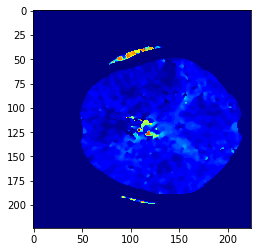

In [15]:
plt.imshow(im[0,0,:,:,0],cmap='jet')

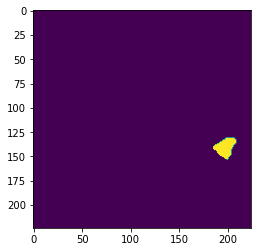

In [16]:
plt.imshow(seg[0,0,:,:,0])

In [17]:
lrs = np.squeeze([np.random.rand(1)*1e-1, np.random.rand(1)*1e-2, np.random.rand(1)*1e-2, np.random.rand(1)*1e-3, np.random.rand(1)*1e-3])
num_epochs = 200


In [18]:
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

In [19]:
post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
global_model = monai.networks.nets.UNet().to(device)

In [22]:
learning_rate = 0.000132#lrs[0] #To comment in the loop
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(global_model.parameters(), lr=learning_rate)

In [23]:
print(learning_rate)

0.000132


In [24]:
# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter(comment=modality+"_FEDAVG_LR_"+str(learning_rate)+"_BATCH_"+str(batch_size))

In [25]:
batch_data = next(iter(c1_train_loader))
#print(batch_data[0].shape)
#batch_data[0][:,:,:,:,0]

In [26]:
batch_data = next(iter(c1_train_loader))
inputs, labels = batch_data[0][:,:,:,:,0].to(device),batch_data[1][:,:,:,:,0].to(device)
#torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device).to(device)
print(inputs.shape,labels.shape)

torch.Size([2, 1, 224, 224]) torch.Size([2, 1, 224, 224])


In [27]:
global_model.train()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

In [28]:
# copy weights
global_weights = global_model.state_dict()

In [29]:
for key in global_weights:
    print(global_weights[key].sum())    

tensor(-1.3790, device='cuda:0')
tensor(-1.0359, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(-2.4708, device='cuda:0')
tensor(-0.0303, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(-3.9149, device='cuda:0')
tensor(0.3286, device='cuda:0')
tensor(-3.1637, device='cuda:0')
tensor(-0.2809, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(-0.7374, device='cuda:0')
tensor(-0.1061, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(1.2495, device='cuda:0')
tensor(0.1613, device='cuda:0')
tensor(-3.9697, device='cuda:0')
tensor(-0.3542, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(-1.3277, device='cuda:0')
tensor(0.1931, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(0.5394, device='cuda:0')
tensor(-0.1832, device='cuda:0')
tensor(-1.6025, device='cuda:0')
tensor(0.1034, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(4.0550, device='cuda:0')
tensor(0.1324, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(11.2147, device='cu

In [30]:
inputs.dtype

torch.float32

In [31]:
#Testing that the model works in one iteration
optimizer.zero_grad()
outputs = global_model(inputs)
loss    = loss_function(outputs, labels)
loss.backward()
optimizer.step()

In [32]:
inputs.shape

torch.Size([2, 1, 224, 224])

In [33]:
labels.shape

torch.Size([2, 1, 224, 224])

In [34]:
def get_optimizer(optimizer_name, cur_lr, model, cur_momentum, weight_decay=1e-4):
    if optimizer_name == 'sgd':
        optimizer_name = optim.SGD(model.parameters(),
                              lr= cur_lr,
                              momentum=cur_momentum)
    elif optimizer_name == 'adam':
        optimizer_name = optim.Adam(model.parameters(),
                               lr=cur_lr,
                               weight_decay=weight_decay)
    return optimizer

In [35]:
global_model.train()
epoch_loss = 0
modelc1, modelc2, modelc4 = copy.deepcopy(global_model), copy.deepcopy(global_model), copy.deepcopy(global_model)

#optimizerc1 = get_optimizer(optimizer_name='adam', cur_lr=learning_rate,  model=modelc1, cur_momentum=0)
#optimizerc2 = get_optimizer(optimizer_name='adam', cur_lr=learning_rate,  model=modelc2, cur_momentum=0)
#optimizerc4 = get_optimizer(optimizer_name='adam', cur_lr=learning_rate,  model=modelc4, cur_momentum=0)

train_loss, train_dice = [], []
#modelc1, modelc2, modelc4 = copy.deepcopy(global_model), copy.deepcopy(global_model), copy.deepcopy(global_model)
for epoch in range(num_epochs):
    #Local update loop
    print("-" * 10)
    print(f"local epoch {epoch + 1}/{num_epochs}")
    
    local_weights, local_losses = [], []
    global_model.train()
    
    global_weights = global_model.state_dict()
    modelc1, modelc2, modelc4 = copy.deepcopy(global_model), copy.deepcopy(global_model), copy.deepcopy(global_model)
    optimizerc1 = torch.optim.Adam(modelc1.parameters(), learning_rate)
    optimizerc2 = torch.optim.Adam(modelc2.parameters(), learning_rate)
    optimizerc4 = torch.optim.Adam(modelc4.parameters(), learning_rate)
    
    modelc1.train()
    modelc2.train()
    modelc4.train()

    batch_loss_c1, epoch_loss_c1 = [], []
    print(f"local epoch for train_loader 1: {epoch + 1}/{num_epochs}")
    for batch_data in c1_train_loader:
        #inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        #Swaping axes to have a batch of Batch_size, Channels, width and height
        #inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device)
        inputs, labels = batch_data[0][:,:,:,:,0].to(device), batch_data[1][:,:,:,:,0].to(device)
        modelc1.zero_grad()        
        #print(inputs.shape)
        outputs = modelc1(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizerc1.step()
        batch_loss_c1.append(loss.item())
    local_losses.append(copy.deepcopy(sum(batch_loss_c1) / len(batch_loss_c1)))
    print("Loss C1: " + str(local_losses[-1]))
    
    batch_loss_c2,epoch_loss_c2 = [], []
    print(f"local epoch for train_loader 2: {epoch + 1}/{num_epochs}")
    for batch_data in c2_train_loader:
        #inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device)
        inputs, labels = batch_data[0][:,:,:,:,0].to(device), batch_data[1][:,:,:,:,0].to(device)
        modelc2.zero_grad()
        outputs = modelc2(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizerc2.step()
        batch_loss_c2.append(loss.item())
    local_losses.append(copy.deepcopy(sum(batch_loss_c2) / len(batch_loss_c2)))
    print("Loss C2: " + str(local_losses[-1]))
    
    
    #C3 is the Siemens data loader for which we have only one data point
    batch_loss_c4,epoch_loss_c4 = [], []
    print(f"local epoch for train_loader 4: {epoch + 1}/{num_epochs}")
    for batch_data in c4_train_loader:
        #inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device)
        inputs, labels = batch_data[0][:,:,:,:,0].to(device), batch_data[1][:,:,:,:,0].to(device)
        modelc4.zero_grad()
        outputs = modelc4(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizerc4.step()
        batch_loss_c4.append(loss.item())
    local_losses.append(copy.deepcopy(sum(batch_loss_c4) / len(batch_loss_c4)))
    print("Loss C4: " + str(local_losses[-1]))
    
    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)
    

    print(f"train_loss: {train_loss[-1]:.4f}")
    writer.add_scalar("train_loss", loss_avg, epoch)        
    
    #Agregating the weights with the FedAvg aproach    
    #global_weights = average_weights([copy.deepcopy(modelc2.state_dict())])
    global_weights = average_weights_with_numsamplesweight([copy.deepcopy(modelc1.state_dict()),copy.deepcopy(modelc2.state_dict()),copy.deepcopy(modelc4.state_dict())],weight_classes)
    # Update global weights with the averaged model weights.
    global_model.load_state_dict(global_weights)
    
    if (epoch + 1) % val_interval == 0:
        global_model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            for val_data in all_valid_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                roi_size = (128, 128)
                sw_batch_size = 1
                val_outputs = global_model(val_images[:,:,:,:,0])
                val_outputs = val_outputs>0.5 #This assumes one slice in the last dim
                dice_metric(y_pred=val_outputs, y=val_labels[:,:,:,:,0])
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(global_model.state_dict(), modality+"_federated_AVG_best_metric_model_segmentation2d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_mean_dice", metric, epoch + 1)


----------
local epoch 1/200
local epoch for train_loader 1: 1/200
Loss C1: 0.9679384604096413
local epoch for train_loader 2: 1/200
Loss C2: 0.9428163085665021
local epoch for train_loader 4: 1/200
Loss C4: 0.9745126724243164
train_loss: 0.9618
----------
local epoch 2/200
local epoch for train_loader 1: 2/200
Loss C1: 0.9631997123360634
local epoch for train_loader 2: 2/200
Loss C2: 0.9325045063382104
local epoch for train_loader 4: 2/200
Loss C4: 0.9736987829208374
train_loss: 0.9565
saved new best metric model
current epoch: 2 current mean dice: 0.3768 best mean dice: 0.3768 at epoch 2
----------
local epoch 3/200
local epoch for train_loader 1: 3/200
Loss C1: 0.9600429460406303
local epoch for train_loader 2: 3/200
Loss C2: 0.9284576035681225
local epoch for train_loader 4: 3/200
Loss C4: 0.967967975139618
train_loss: 0.9522
----------
local epoch 4/200
local epoch for train_loader 1: 4/200
Loss C1: 0.9586041569709778
local epoch for train_loader 2: 4/200
Loss C2: 0.92763586839040

Loss C1: 0.9618208259344101
local epoch for train_loader 2: 29/200
Loss C2: 0.929922566527412
local epoch for train_loader 4: 29/200
Loss C4: 0.9761750936508179
train_loss: 0.9560
----------
local epoch 30/200
local epoch for train_loader 1: 30/200
Loss C1: 0.9602549895644188
local epoch for train_loader 2: 30/200
Loss C2: 0.929525165330796
local epoch for train_loader 4: 30/200
Loss C4: 0.9781901240348816
train_loss: 0.9560
current epoch: 30 current mean dice: 0.4579 best mean dice: 0.5088 at epoch 24
----------
local epoch 31/200
local epoch for train_loader 1: 31/200
Loss C1: 0.9625479429960251
local epoch for train_loader 2: 31/200
Loss C2: 0.9285605691728138
local epoch for train_loader 4: 31/200
Loss C4: 0.977494764328003
train_loss: 0.9562
----------
local epoch 32/200
local epoch for train_loader 1: 32/200
Loss C1: 0.9590500667691231
local epoch for train_loader 2: 32/200
Loss C2: 0.9295255172820318
local epoch for train_loader 4: 32/200
Loss C4: 0.9771817445755004
train_loss: 

Loss C4: 0.9730707406997681
train_loss: 0.9536
----------
local epoch 58/200
local epoch for train_loader 1: 58/200
Loss C1: 0.9606444239616394
local epoch for train_loader 2: 58/200
Loss C2: 0.9285167597589039
local epoch for train_loader 4: 58/200
Loss C4: 0.972669804096222
train_loss: 0.9539
current epoch: 58 current mean dice: 0.4597 best mean dice: 0.5088 at epoch 24
----------
local epoch 59/200
local epoch for train_loader 1: 59/200
Loss C1: 0.9606919139623642
local epoch for train_loader 2: 59/200
Loss C2: 0.9310169163204375
local epoch for train_loader 4: 59/200
Loss C4: 0.9741514444351196
train_loss: 0.9553
----------
local epoch 60/200
local epoch for train_loader 1: 60/200
Loss C1: 0.9601928070187569
local epoch for train_loader 2: 60/200
Loss C2: 0.9303767170224871
local epoch for train_loader 4: 60/200
Loss C4: 0.9738846063613892
train_loss: 0.9548
current epoch: 60 current mean dice: 0.4467 best mean dice: 0.5088 at epoch 24
----------
local epoch 61/200
local epoch for 

Loss C1: 0.9597070589661598
local epoch for train_loader 2: 86/200
Loss C2: 0.9289266892841884
local epoch for train_loader 4: 86/200
Loss C4: 0.9695591449737548
train_loss: 0.9527
current epoch: 86 current mean dice: 0.4386 best mean dice: 0.5088 at epoch 24
----------
local epoch 87/200
local epoch for train_loader 1: 87/200
Loss C1: 0.959390290081501
local epoch for train_loader 2: 87/200
Loss C2: 0.9284236289206005
local epoch for train_loader 4: 87/200
Loss C4: 0.9703977346420288
train_loss: 0.9527
----------
local epoch 88/200
local epoch for train_loader 1: 88/200
Loss C1: 0.9586488679051399
local epoch for train_loader 2: 88/200
Loss C2: 0.9295268030393691
local epoch for train_loader 4: 88/200
Loss C4: 0.9707183837890625
train_loss: 0.9530
current epoch: 88 current mean dice: 0.4445 best mean dice: 0.5088 at epoch 24
----------
local epoch 89/200
local epoch for train_loader 1: 89/200
Loss C1: 0.9600296318531036
local epoch for train_loader 2: 89/200
Loss C2: 0.932861839021955

Loss C2: 0.9281847249893915
local epoch for train_loader 4: 114/200
Loss C4: 0.9694364070892334
train_loss: 0.9522
current epoch: 114 current mean dice: 0.4275 best mean dice: 0.5088 at epoch 24
----------
local epoch 115/200
local epoch for train_loader 1: 115/200
Loss C1: 0.9602832272648811
local epoch for train_loader 2: 115/200
Loss C2: 0.9281851620901198
local epoch for train_loader 4: 115/200
Loss C4: 0.9696042895317077
train_loss: 0.9527
----------
local epoch 116/200
local epoch for train_loader 1: 116/200
Loss C1: 0.9614027664065361
local epoch for train_loader 2: 116/200
Loss C2: 0.9277328451474508
local epoch for train_loader 4: 116/200
Loss C4: 0.9687635898590088
train_loss: 0.9526
current epoch: 116 current mean dice: 0.4451 best mean dice: 0.5088 at epoch 24
----------
local epoch 117/200
local epoch for train_loader 1: 117/200
Loss C1: 0.9590916261076927
local epoch for train_loader 2: 117/200
Loss C2: 0.9287024963469732
local epoch for train_loader 4: 117/200
Loss C4: 0

Loss C2: 0.9317728082338969
local epoch for train_loader 4: 142/200
Loss C4: 0.9691061019897461
train_loss: 0.9535
current epoch: 142 current mean dice: 0.4454 best mean dice: 0.5088 at epoch 24
----------
local epoch 143/200
local epoch for train_loader 1: 143/200
Loss C1: 0.9589028209447861
local epoch for train_loader 2: 143/200
Loss C2: 0.92911240032741
local epoch for train_loader 4: 143/200
Loss C4: 0.9698412656784058
train_loss: 0.9526
----------
local epoch 144/200
local epoch for train_loader 1: 144/200
Loss C1: 0.9601568207144737
local epoch for train_loader 2: 144/200
Loss C2: 0.9294579795428685
local epoch for train_loader 4: 144/200
Loss C4: 0.9682793855667114
train_loss: 0.9526
current epoch: 144 current mean dice: 0.4485 best mean dice: 0.5088 at epoch 24
----------
local epoch 145/200
local epoch for train_loader 1: 145/200
Loss C1: 0.958989255130291
local epoch for train_loader 2: 145/200
Loss C2: 0.9302833278973898
local epoch for train_loader 4: 145/200
Loss C4: 0.97

Loss C2: 0.9282427713984535
local epoch for train_loader 4: 170/200
Loss C4: 0.9694628715515137
train_loss: 0.9525
current epoch: 170 current mean dice: 0.4436 best mean dice: 0.5088 at epoch 24
----------
local epoch 171/200
local epoch for train_loader 1: 171/200
Loss C1: 0.9589867889881134
local epoch for train_loader 2: 171/200
Loss C2: 0.9287444040888831
local epoch for train_loader 4: 171/200
Loss C4: 0.9699801445007324
train_loss: 0.9526
----------
local epoch 172/200
local epoch for train_loader 1: 172/200
Loss C1: 0.9626290649175644
local epoch for train_loader 2: 172/200
Loss C2: 0.9294707122303191
local epoch for train_loader 4: 172/200
Loss C4: 0.9683277368545532
train_loss: 0.9535
current epoch: 172 current mean dice: 0.4635 best mean dice: 0.5088 at epoch 24
----------
local epoch 173/200
local epoch for train_loader 1: 173/200
Loss C1: 0.9593634009361267
local epoch for train_loader 2: 173/200
Loss C2: 0.9286154395058042
local epoch for train_loader 4: 173/200
Loss C4: 0

Loss C2: 0.928619608992622
local epoch for train_loader 4: 198/200
Loss C4: 0.9697206258773804
train_loss: 0.9525
current epoch: 198 current mean dice: 0.4612 best mean dice: 0.5088 at epoch 24
----------
local epoch 199/200
local epoch for train_loader 1: 199/200
Loss C1: 0.9601841494441032
local epoch for train_loader 2: 199/200
Loss C2: 0.934004423164186
local epoch for train_loader 4: 199/200
Loss C4: 0.9683767795562744
train_loss: 0.9542
----------
local epoch 200/200
local epoch for train_loader 1: 200/200
Loss C1: 0.9591148346662521
local epoch for train_loader 2: 200/200
Loss C2: 0.9291271283513024
local epoch for train_loader 4: 200/200
Loss C4: 0.9723428726196289
train_loss: 0.9535
current epoch: 200 current mean dice: 0.4562 best mean dice: 0.5088 at epoch 24


In [36]:
!pwd

/home/otalora/miccai22


In [37]:
modality

'Tmax'

## Testing the best validation model in an unseen test volume (slice-wise)


In [38]:
ep= 40
cur_checkpoint_path = '/home/otarola/miccai22/metric_model_segmentation2d_array_ep_'+str(ep)+'.pth'

checkpoint = torch.load('/home/otarola/miccai22/'+modality+'_federated_AVG_best_metric_model_segmentation2d_array.pth')

global_model.load_state_dict(checkpoint)
outputs = global_model(inputs)



In [39]:
print(modality)

Tmax


In [40]:
count_volume = 0
dice_metric.reset()
metric_values_test = []
for test_data in all_test_loader:
    count_volume = count_volume+1
    cur_image, cur_label = test_data
    cur_outputs = []
    cur_labels  = []
    labels   = torch.tensor(cur_label).to(device)
    for ct_slice in range(cur_image.shape[-1]):
        cur_ct_slice = torch.tensor(cur_image[:,:,:,:,ct_slice]).to(device)        
        label    = labels[:,:,:,:,ct_slice]
        outputs = global_model(cur_ct_slice)

        cur_outputs.append(outputs.cpu().detach().numpy()>0.5)
        cur_labels.append(label.cpu().detach().numpy()>0.5)
        #print(torch.tensor(cur_outputs[-1]).shape)
        #print(torch.tensor(cur_labels[-1]).shape)
        dice_metric(y_pred=torch.tensor(cur_outputs[-1]), y=torch.tensor(cur_labels[-1]))

    # aggregate the final mean dice result
    metric = dice_metric.aggregate().item()
    dice_metric.reset()
    metric_values_test.append(metric)
print("AVG TEST DICE SCORE FOR LEARNING RATE "+str(learning_rate) + ": " + str(np.mean(metric_values_test)) + " - STD: " + str(np.std(metric_values_test)))

/tmp/ipykernel_2996795/3027378860.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels   = torch.tensor(cur_label).to(device)
/tmp/ipykernel_2996795/3027378860.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cur_ct_slice = torch.tensor(cur_image[:,:,:,:,ct_slice]).to(device)


AVG TEST DICE SCORE FOR LEARNING RATE 0.000132: 0.40831694652636846 - STD: 0.2955684548567093


In [41]:
modality

'Tmax'

In [42]:
torch.tensor(label.cpu().detach().numpy()>0.5).shape

torch.Size([1, 1, 224, 224])

In [43]:
metric_values_test

[0.20762594044208527,
 0.3941236138343811,
 0.07199297845363617,
 0.04296388477087021,
 0.7524344325065613,
 0.7241988182067871,
 0.2197580635547638,
 0.721306324005127,
 0.7161716222763062,
 0.7396162152290344,
 0.4236111044883728,
 0.06390823423862457,
 0.0,
 0.8018816709518433,
 0.2451612949371338]

In [44]:
path_test_case = '/str/data/ASAP/miccai22_data/isles/federated/center1/test/case_21/SMIR.Brain.XX.O.CT_CBF.345691/SMIR.Brain.XX.O.CT_CBF.345691.nii'
path_test_label= '/str/data/ASAP/miccai22_data/isles/federated/center1/test/case_21/SMIR.Brain.XX.O.OT.345694/SMIR.Brain.XX.O.OT.345694.nii'

test_vol = nib.load(path_test_case)
test_lbl = nib.load(path_test_label)

test_vol_pxls = test_vol.get_fdata()
test_vol_pxls = np.array(test_vol_pxls, dtype = np.float32)
test_lbl_pxls = test_lbl.get_fdata()
test_lbl_pxls = np.array(test_lbl_pxls)
test_vol_pxls[test_vol_pxls>1200] = 0

print(test_vol_pxls.shape, test_lbl_pxls.shape)

(256, 256, 2) (256, 256, 2)


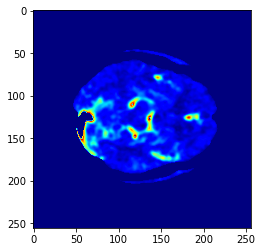

In [45]:
plt.imshow(test_vol_pxls[:,:,1],cmap='jet')

In [46]:
out_test = global_model(torch.tensor(test_vol_pxls[np.newaxis, np.newaxis, :,:,1]/1200).to(device))
out_test = out_test.detach().cpu().numpy()

In [47]:
pred = np.array(out_test[0,0,:,:]>0.5, dtype='uint8')

In [48]:
gt_lbl = test_lbl_pxls[:,:,1]

In [49]:
dice_metric(torch.tensor(pred[np.newaxis,np.newaxis,:,:]),torch.tensor(pred[np.newaxis,np.newaxis,:,:]))

tensor([[nan]])

In [50]:
out_test.shape

(1, 1, 256, 256)

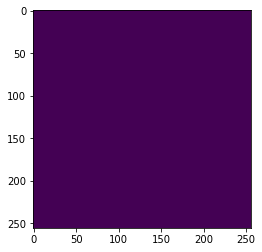

In [51]:
plt.imshow(out_test[0,0,:,:]>0.9)

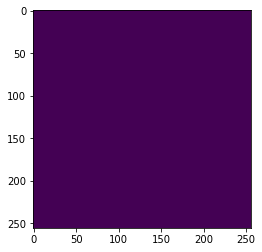

In [52]:
plt.imshow(test_lbl_pxls[:,:,0])

In [53]:
metric_values_test

[0.20762594044208527,
 0.3941236138343811,
 0.07199297845363617,
 0.04296388477087021,
 0.7524344325065613,
 0.7241988182067871,
 0.2197580635547638,
 0.721306324005127,
 0.7161716222763062,
 0.7396162152290344,
 0.4236111044883728,
 0.06390823423862457,
 0.0,
 0.8018816709518433,
 0.2451612949371338]

In [54]:
pp = np.array(outputs.cpu().detach().numpy()>0.9, dtype='uint8')[0,0,:,:]
pp[pp<=0] = 1

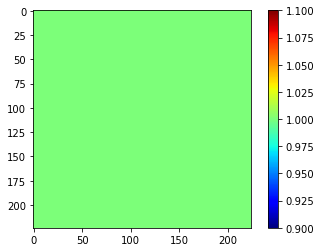

In [55]:
plt.imshow(pp,cmap='jet')
plt.colorbar()

In [56]:
label[0,0,:,:].cpu().detach().numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

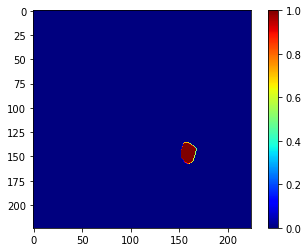

In [57]:
plt.imshow(label[0,0,:,:].cpu().detach().numpy(),cmap='jet')
plt.colorbar()

In [58]:
plt.colorbar

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

In [59]:
label.shape

torch.Size([1, 1, 224, 224])

In [60]:
metric

0.2451612949371338

In [61]:
len(c4_test_loader)

2

In [62]:
len(c3_test_loader)

1

In [63]:
len(c1_train_loader)

8

In [64]:
len(c1_valid_loader)

3

In [65]:
len(c1_test_loader)

4

In [66]:
len(c2_train_loader)

21